In [4]:
from toolz import *

import pandas as pd
import numpy as np
from scipy.special import expit

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("ggplot")

# 24 - The Difference-in-Differences Saga

치료 효과의 이질성에 대해 논의한 후, 이제 다시 평균 치료 효과로 방향을 전환하겠습니다. 앞으로 몇 장에 걸쳐 패널 데이터 방법의 최근 발전에 대해 살펴보겠습니다. 패널은 시간에 걸쳐 관찰이 반복되는 데이터 구조입니다. 동일한 단위를 여러 기간에 걸쳐 관찰하기 때문에 치료가 이루어지기 전과 후에 어떤 일이 일어나는지 확인할 수 있습니다. 따라서 패널 데이터는 무작위 배정이 불가능할 때 인과 관계를 파악할 수 있는 유력한 대안이 될 수 있습니다.

패널 데이터 사용에 대한 동기를 부여하기 위해 주로 마케팅에 대한 인과관계 추론 적용에 대해 이야기하겠습니다. 마케팅은 무작위 실험을 실행하기 어렵기로 악명이 높기 때문에 특히 흥미롭습니다. 마케팅에서는 누가 치료를 받는지, 즉 누가 광고를 보는지 통제할 수 없는 경우가 많습니다. 새로운 사용자가 우리 사이트를 방문하거나 앱을 다운로드할 때, 그 사용자가 우리 캠페인 중 하나를 보고 왔는지 아니면 다른 요인으로 인해 왔는지 알 수 있는 좋은 방법이 없습니다.

(OBS: 마케팅 어트리뷰션에 대해 잘 알고 계신 분들을 위해 이 문제를 해결하기 위한 많은 어트리뷰션 툴이 있다는 것을 알고 있습니다. 하지만 여러 가지 한계가 있다는 것도 잘 알고 있습니다.)

오프라인 마케팅의 경우 문제는 더욱 심각합니다. TV 캠페인이 비용 이상의 가치를 창출했는지 어떻게 알 수 있을까요? 그래서 마케팅 업계에서는 어떤 지역에는 마케팅 캠페인을 진행하고 다른 지역에는 하지 않는 지리적 실험을 실시하여 비교하는 경우가 많습니다. 이 설계에서는 패널 데이터 방법이 특히 흥미로운데, 여러 기간에 걸쳐 전체 지역(단위)에 대한 데이터를 수집할 수 있기 때문입니다. 이러한 종류의 데이터를 이해하고 인과 관계를 파악하기 위해 가장 많이 사용되는 방법은 Diff-in-Diff(DiD) 제품군에 속하는 방법일 것입니다.

2020년과 2021년은 우리 모두에게 쉽지 않은 한 해였습니다. 특히 DiD에 있어서는 더욱 힘들었습니다. 최근의 많은 연구에서 이러한 방법의 심각한 결함, 즉 과거에는 잘 알려지지 않았던 결함이 강조되었습니다. 따라서 파트 1에 이미 DiD를 다루는 장이 있지만, 그 내용은 다소 입문적인 수준입니다. 패널 데이터 방법에 대한 새로운 발견과 활발한 논의는 다루지 않았습니다. 이제 Diff-in-Diff부터 시작하여 좀 더 자세히 살펴볼 필요가 있습니다. 이 특정 장에서는 최근에 발견된 Diff-in-Diff의 문제점을 요약하고 이를 해결하는 방법을 보여드리려고 합니다. 이 장은 세 개의 섹션으로 나뉩니다:

1. Birth: 패널 데이터가 인과 관계 추론에 매력적인 이유와 디프인디프와 양방향 고정 효과(TWFE)가 시간적 구조를 유리하게 활용하는 방법을 요약합니다.

2. Death: DiD 및 TWFE 모델이 간과하고 있는 한 가지 핵심 가정을 정리합니다. 이 가정이 언제 어떻게 실패할 수 있는지 이해합니다.

2. Enlightenment: DiD와 TWFE의 문제점을 알았으니 이제 그 해결책을 생각해 볼 수 있습니다. 이 부분에서는 섹션 2에서 살펴본 문제에 대한 간단한 해결 방법을 보여줍니다.

바로 시작하겠습니다!


## 1) Birth: The Promise of Panel Data

![img](./data/img/diff-in-diff-saga/promise.png)

앞서 말했듯이 패널 데이터는 여러 기간 `t`에 걸쳐 여러 단위 `i`가 있는 경우입니다. 대마초 합법화가 범죄율에 미치는 영향을 확인하려는 미국의 정책 평가 시나리오를 생각해 보겠습니다. 여러 기간에 걸친 여러 주 `i`에 대한 범죄율 데이터가 있고, 각 주가 대마초 합법화 방향으로 법안을 채택하는 시점을 관찰합니다. 이것이 왜 인과 관계 추론에 매우 강력한지 알 수 있기를 바랍니다. 대마초 합법화를 치료 `D`라고 부릅니다(`T`가 취해졌으므로 시간을 나타냄). 결국 치료를 받게 되는 특정 주의 범죄율 추세를 추적하고 치료 시점에 추세에 변화가 있는지 확인할 수 있습니다. 어떤 의미에서 주(州)는 전후 비교에서 자체적인 제어 장치 역할을 합니다. 또한 여러 상태가 있기 때문에 처리된 상태와 대조 상태를 비교할 수도 있습니다. 치료 상태와 대조 상태, 치료 전과 치료 후의 두 가지 비교를 모두 합치면 반증과 인과 효과를 추론할 수 있는 매우 강력한 도구가 됩니다.

패널 데이터 방법은 정부 정책 평가에 자주 사용되지만, (기술) 산업에도 매우 유용한 이유는 쉽게 설명할 수 있습니다. 기업은 여러 기간에 걸쳐 사용자 데이터를 추적하는 경우가 많기 때문에 패널 데이터 구조가 풍부합니다. 뿐만 아니라 때로는 실험이 불가능하기 때문에 다른 식별 전략에 의존해야 할 때도 있습니다. 이 아이디어를 더 자세히 살펴보기 위해 여러 도시에서 앱을 설치한 사람들의 수를 추적하는 한 젊은 기술 회사의 가상 사례를 고려해 보겠습니다. 2021년 어느 날, 이 기술 회사는 앱에 새로운 기능을 출시했습니다. 이제 이 회사는 이 기능이 회사에 얼마나 많은 새로운 사용을 가져왔는지 알고 싶어합니다. 이 기능은 점진적으로 출시되었습니다. 일부 도시에서는 `2021-06-01`에 기능이 출시되었습니다. 다른 도시에서는 `2021-07-15`에 출시되었습니다. 나머지 도시에 대한 전체 출시는 2022년에야 이루어집니다. 데이터는 `2021-07-31`까지만 올라가므로 이 마지막 그룹을 대조군으로 간주할 수 있습니다. 인과관계 추론 측면에서 이 기능의 출시는 치료로 볼 수 있고 설치 횟수는 결과로 볼 수 있습니다. 우리는 결과에 대한 치료 효과, 즉 새로운 기능이 설치 횟수에 미치는 영향을 알고 싶습니다.

여기서 기술 회사가 어떻게 실험을 할 수 없는지 주목하세요. 어떤 사람이 새로운 기능이 있다는 것을 알게 되는지 통제할 수 없습니다. 우리는 그들이 치료 할당에 대한 통제력이 제한적이라고 말합니다. 분석의 단위가 **아직 고객이 아닌 사람들이기 때문입니다**. 그들은 앱을 설치함으로써 얼마나 많은 사람들을 고객으로 전환할 수 있는지 알고 싶어합니다. 물론 이러한 사람들을 무작위로 배정할 수는 없습니다. 그래서 대신 분석 단위를 도시로 변경했습니다. 한 도시와 다른 도시에서의 출시는 통제할 수 있지만, 한 사람에 대한 출시와 다른 사람에 대한 출시는 그렇지 않습니다.

특정 시점에 해당 기능(치료)을 받은 도시 그룹을 코호트라고 합니다. 저희의 경우 `2021-06-01`에 치료를 받은 코호트, `2021-07-15`에 치료를 받은 코호트, 그리고 데이터가 종료된 후에만 치료를 받은 대조 코호트 등 세 개의 코호트가 있습니다. 이 데이터가 어떻게 보이는지 파악하기 위해 코호트별로 그룹화된 일일 평균 설치 수를 플롯해 보겠습니다.

In [6]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"] + d["w_seas"]/10,
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

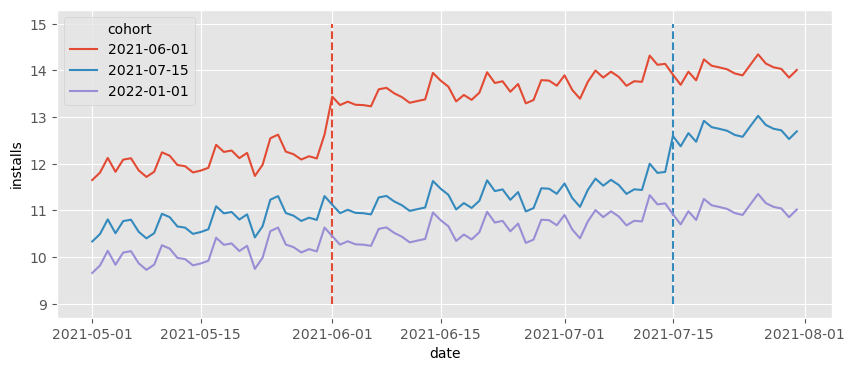

In [7]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

점선은 코호트가 치료를 받은 시점(기능이 출시된 시점)을 표시합니다. 잠시 시간을 내어 위 그림에 묘사된 풍부한 데이터를 살펴보시기 바랍니다. 먼저, 각 코호트마다 고유한 기준 수준이 있음을 알 수 있습니다. 이는 도시마다 인구 규모가 다르기 때문에 도시 규모에 따라 설치 수가 더 많거나 적기 때문입니다. 예를 들어, 첫 번째 코호트(06/01년 처리)의 도시가 다른 코호트의 도시에 비해 기준선이 더 높은 것처럼 보입니다. 또한 대조군 코호트는 인스톨 기준선이 더 낮은 것처럼 보입니다. 즉, 치료받은 코호트와 대조 코호트를 단순히 비교하면 대조 코호트의 $Y_0$이 치료받은 코호트의 $Y_0$보다 낮거나 $Y_0\mid G=Control < Y_0\mid G= Treated$이기  때문에 편향된 결과가 나올 수 있습니다. 여기서 $G$는 코호트를 나타냅니다. 다행히도 이것은 문제가 되지 않습니다. 패널 데이터를 사용하면 여러 도시와 시간에 걸쳐 비교할 수 있으므로 다양한 기준선에 맞게 조정할 수 있습니다.

시간에 대해 말하자면, 약간의 흔들림(주간 계절성처럼 보이는)이 있는 전반적인 상승 추세가 있음을 알 수 있습니다. 대조군 코호트에 초점을 맞추면 일일 설치 수가 5월에 약 10건에서 6월에 약 11건으로 약 1건 증가한 것처럼 보입니다. 기술적인 측면에서 보면, 후반의 기간이 초반의 기간보다 $Y_0$ 이 초기 기간보다 높습니다. 즉, 같은 도시를 시간대별로 단순 비교하면 편향된 결과가 나올 수 있습니다. 패널 데이터 구조를 통해 시간 간 비교뿐만 아니라 도시 간 비교를 통해 추세를 조정할 수 있다는 점은 다행스러운 일입니다.

이상적으로는 이 새로운 기능의 출시가 설치에 미친 영향을 추론하기 위해, 해당 기능을 사용하지 않았을 경우 해당 기능을 사용한 코호트에서 어떤 일이 일어났을지 알고 싶습니다. 치료받은 코호트의 치료 후 기간에 대한 반대 결과 $Y_0$을 추정하고 싶습니다. 각 코호트를 치료받은 시간 `g`로 표시하면(코호트는 같은 시기에 치료를 받은 도시들의 그룹이라는 점을 기억하세요), 이 역효과를 $E[Y_0\mid t\geq g]$로 쓸 수 있습니다. 그러면 다음과 같이 코호트 `g`에 대한 치료 대상에 대한 치료 효과(ATT)를 정의할 수 있습니다:

$$ E[Y_1\mid t\geq g] - E[Y_0 \mid t\geq g]$$

다음 질문은 우리가 가지고 있는 데이터로 어떻게 이를 추정할 수 있는가 하는 것입니다. 한 가지 방법은 패널 데이터 구조의 힘을 활용하여 이러한 반실제를 추정하는 것입니다. 예를 들어, 선형 회귀와 Diff-in-Diff 공식을 사용하여 양방향 고정 효과 모델을 얻을 수 있습니다. 각 도시 `i`에 기본 설치 수준 $\gamma_i$가 있다고 가정해 보겠습니다. 이는 앞서 살펴본 것과 관련이 있습니다. 한 도시의 인구가 더 많거나 그 도시의 문화가 우리 기술 회사의 제품에 더 부합하기 때문에 설치 수가 더 많을 수도 있습니다. 이유가 무엇이든, 그리고 이유를 모르더라도 이러한 단위의 특성은 **시간 고정 매개변수** $\gamma_i$로 포착할 수 있다고 말합니다. 마찬가지로, 각 기간 `t`에는 **단위 고정 파라미터** $\theta_t$로 캡처할 수 있는 기준 설치 수준이 있다고 말할 수 있습니다. 이 경우 설치를 모델링하는 좋은 방법은 도시(단위) 효과 $\gamma$와 시간 효과 $\theta$, 그리고 약간의 무작위 노이즈에 따라 달라진다고 말하는 것입니다.

$$ Installs_{it} = \gamma_i + \theta_t + e_{it}$$

이 그림에 처리를 포함하기 위해 변수 $D_{it}$를 정의해 보겠습니다. 변수를 정의해 보겠습니다. 이 변수는 유닛이 처리되면 1이 되고 그렇지 않으면 0이 됩니다. 이 예에서 이 변수는 치료를 받지 않은 코호트에 대해 항상 0이 됩니다. 다른 모든 코호트도 처음에는 0이지만, 06/01에 치료를 받은 코호트의 경우 06/01에 1로 바뀌고 그 이후에는 1을 유지합니다. 또한 07/15에 치료받은 코호트의 경우 07/15에 1이 됩니다. 이러한 치료 지표를 다음과 같이 설치 모델에 포함할 수 있습니다:

$$ Installs_{it} = \tau \D_{it} + \gamma_i + \theta_t + e_{it}$$

위의 모델을 OLS로 추정하는 것을 양방향 고정 효과 모델(TWFE)이라고 합니다. 주목할 점은 $\tau$ 는 유닛이 처리된 후 설치 수가 얼마나 변화하는지 알려주는 처리 효과입니다.

이를 바라보는 또 다른 방법은 선형 회귀의 "불변량 유지" 적합성을 호출하는 것입니다. 위의 모델을 추정하면 $\tau$의 추정치를 읽을 수 있습니다. 의 추정치를 단위 i와 시간 t를 고정된 상태로 유지한 상태에서 처리를 0에서 1로 바꾸면 설치 수가 얼마나 변할지 알 수 있습니다.

얼마나 대담한지 주목하세요! 각 단위를 고정된 상태로 유지하면서 $D$가 결과를 어떻게 변화시키는지 확인한다는 것은 알려진 것과 알려지지 않은, 시간에 따라 일정한 모든 단위별 특성을 통제한다고 말하는 것입니다. 예를 들어, 도시의 기본 설치 수준은 측정할 수 있지만 도시 문화가 우리 제품에 얼마나 부합하는지와 같이 우리가 알 수 없는 요소도 통제할 수 있습니다. 유일한 요구 사항은 이 특성이 분석 기간 동안 고정되어 있어야 한다는 것입니다. 또한 각 기간을 고정한다고 말하는 것은 연도별 특성을 모두 통제한다고 말하는 것과 같습니다. 예를 들어, 연도를 고정하고 있으므로 $D$의 효과를 살펴볼 때 의 효과를 살펴보는 동안 앞서 살펴본 추세와 계절성을 통제하게 됩니다.

이 모든 기능이 실제로 작동하는지 확인하려면 치료 지표 $D$(여기서 `처리`)와 단위 및 시간에 대한 더미를 사용하여 OLS 모델을 실행하기만 하면 됩니다. 특정 예제에서는 처리(새 기능)의 효과가 설치 수를 1 증가시키는 방식으로 데이터를 생성했습니다. TWFE가 이 처리 효과를 완벽하게 복구하는 방법을 살펴보십시오:

In [9]:
formula = f"""installs ~ treat + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df).fit()

twfe_model.params["treat"]

1.0000000000000673

위의 데이터를 시뮬레이션했기 때문에 실제 개별 치료 효과를 정확히 알 수 있으며, 이는 `tau` 열에 저장됩니다. TWFE는 치료 대상에 대한 치료 효과를 회복해야 하므로 실제 ATT가 위에서 추정된 것과 일치하는지 확인할 수 있습니다. 치료 단위와 기간을 필터링(`treat==1`)하고 `tau` 열의 평균을 구하기만 하면 됩니다.

In [10]:
df.query("treat==1")["tau"].mean()

1.0

빅데이터로 각 단위마다 하나의 더미 열을 생성하는 것이 불가능하다고 말하는 사람이 있기 전에, 제가 먼저 말씀드리자면, 그것은 사실입니다. 하지만 쉽게 해결할 수 있는 방법이 있습니다. FWL 정리를 사용하여 단일 회귀를 두 개로 분할할 수 있습니다. 실제로 위의 모델을 실행하는 것은 다음 모델을 추정하는 것과 수치적으로 동일합니다.

$$ \tilde{Installs}_{it} = \tau\tilde{D}_{it} + e_{it}$$

이때 

$$ \tilde{Installs}_{it} = Installs_{it} - \frac{1}{T} \sum_{t=0}^T Installs_{it} - \frac{1}{N} \sum_{i=0}^N Installs_{it}$$

이고,

$$ \tilde{D}_{it} = D_{it} - \frac{1}{T} \sum_{t=0}^T D_{it} - \frac{1}{N} \sum_{i=0}^N D_{it}$$

이제 수학이 너무 복잡해지면 치료 지표와 결과 변수 모두에서 시간 간 단위 평균(첫 번째 학기)과 단위 간 시간 평균(두 번째 학기)을 빼서 잔차값을 축소합니다. 결과와 치료에서 평균을 빼기 때문에 이 과정을 흔히 의미 제거라고 합니다. 마지막으로, 코드에서도 동일한 작업을 수행합니다:

In [11]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("unit")[col_to_demean].transform("mean")
                                        - df.groupby("date")[col_to_demean].transform("mean"))})


formula = f"""installs ~ treat"""
mod = smf.ols(formula,
              data=df
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="installs")))

result = mod.fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-11.4580,3.94e-16,-2.91e+16,0.000,-11.458,-11.458
treat,1.0000,9.95e-16,1.01e+15,0.000,1.000,1.000


TWFE 모델이 무엇을 하고 있는지 이해하기 위해 할 수 있는 또 다른 방법은 반사실 예측 $\hat{Y_0} \mid t \geq g$ 를 플롯하는 것입니다. 이는 모델이 치료 효과 $\hat{\tau}$를 단순히 추정된 차이 $Y_1 - \hat{Y_0}$로 보기 때문에 유용합니다. 이 명시적인 차이를 보면 모델이 무엇을 하고 있는지 어느 정도 알 수 있습니다. 아래 그림에서 점선으로 표시된 $\hat{Y_0}$을 정확히 확인할 수 있습니다.

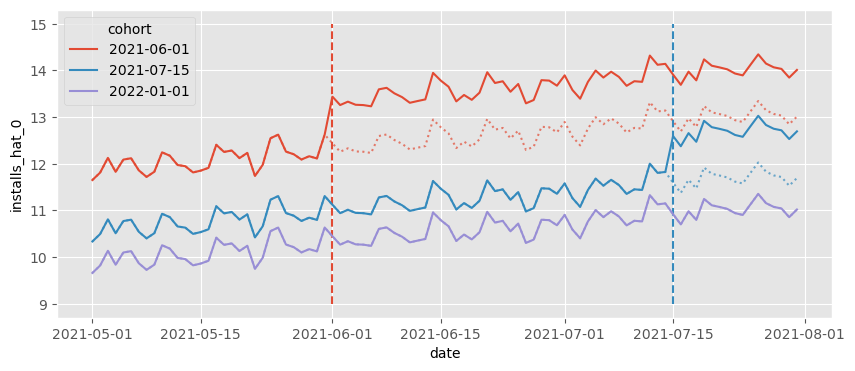

In [12]:
df_pred = df.assign(**{"installs_hat_0": twfe_model.predict(df.assign(**{"treat":0}))})
          

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    hue="cohort",
    alpha=0.7,
    ls="dotted",
    legend=None
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

이 도표는 TWFE가 대조군에서 관찰한 추세를 치료군으로 투영하고 수준을 조정하는 방법을 보여줍니다. 예를 들어 빨간색 코호트를 보면, 사실과 반대되는 $Y_0$은 는 파란색과 보라색 코호트의 평균 추세(추세 투영)를 빨간색 코호트의 수준으로 이동시킨 것입니다(수준 조정). 이것이 바로 TWFE를 차이 내 차이 방법으로 보는 이유입니다. 이 방법도 추세 예측과 수준 조정을 수행하지만 여러 기간과 여러 단위에서 작동합니다(2단위×2기간의 경우, TWFE와 DiD는 동일합니다).

## 2) Death: Failures over Effect Heterogeneity

방금 살펴본 것처럼 DiD와 TWFE에는 장점이 있습니다. 시간 및 단위별 변수를 모두 수용하여 반사실을 매우 잘 추정할 수 있습니다. 따라서 강력한 인과관계 추론 기법이 될 수 있습니다. 하지만 이것이 전부라면 이 책의 1부에서 충분히 다루었기 때문에 이 장은 필요 없을 것입니다. 최근 많은 학자들이 TWFE를 사용하여 2×2 DiD를 여러 기간으로 확장하는 것이 우리가 처음 생각했던 것만큼 간단하지 않다는 사실을 알게 되었습니다. 실제로 **TWFE는 일반적인 공식에서 많은 실제 응용 분야에서 편향된 것으로 밝혀졌습니다**. 이 사건으로 인해 이 기법에 의존하는 여러 경제학 연구에서 수정의 물결이 일었습니다. 이 모든 것을 이해하려면 기본 가정을 설명하는 것부터 시작하는 것이 가장 좋습니다.

![img](./data/img/diff-in-diff-saga/death.png)

간단하게 하기 위해 시간 효과가 없는 FE 모델을 고려해 보겠습니다:
$$y_{it} = \tau D_{it} + \gamma_i + e_{it}$$

이 모델의 가정을 두 가지 그룹으로 분류할 수 있습니다.

1. 기능적 형태 가정:
    - 시간에 따른 이질적인 효과 없음(상수 효과);
    - 공변량의 선형성;
    - 추가 고정 효과.

2. 엄격한 외생성
    - 평행 추세
    - 예측 없음
    - 관찰되지 않은 시간 변화 교란변수 없음
    - 과거 치료가 현재 결과에 영향을 미치지 않음(이월 없음)
    - 과거 치료 결과가 현재 치료에 영향을 미치지 않음(피드백 없음)

여기서는 함수형 가정을 고수하겠습니다. 공변량의 선형성은 매우 잘 알려져 있으며 모든 선형 회귀 모델에 적용됩니다. 그러나 이중/디베이즈 머신 러닝 장에서 살펴본 것처럼 머신 러닝 모델을 사용하면 이러한 가정을 쉽게 완화할 수 있습니다. 즉, 원하는 경우 이 가정을 완화할 수 있습니다. 추가 고정 효과에 관해서는 너무 제한적인 가정이 아니므로 많은 문제를 일으키지 않습니다. 제가 집중하고 싶은 것은 (그리고 많은 소란을 일으켰던) 시간 내 이질적 효과가 없다는 가정입니다.

## Treatment Effect Heterogeneity in Time


마케팅이나 기술 분야에서 일해 본 적이 있다면 성숙하는 데 시간이 걸린다는 것을 잘 알고 있을 것입니다. 새로운 기능을 출시하면 사용자가 익숙해지는 데 시간이 걸립니다. 마찬가지로 마케팅 캠페인을 시작하면 그 효과가 즉각적으로 나타나지 않습니다. 시간이 지남에 따라 성숙해지고 캠페인이 끝난 후에도 새로운 사용자가 유입될 수 있습니다. 이는 앞서 살펴본 설치 데이터에서 **볼 수 있었던 패턴이 아닙니다**. 여기서는 코호트가 처리되는 순간 설치 수가 즉각적으로 급증했습니다. 이를 현실에 더 부합하도록 변경하면 어떻게 될까요? 즉, ATT가 여전히 1이지만 이제는 성숙하는 데 10일이 걸리도록 만들어 보겠습니다(따라서 첫 번째 치료일에는 0.1, 두 번째 치료일에는 0.2가 되어 10일째에 1이 될 때까지). 또한 시간 및 단위 효과의 크기를 줄여 전체 추세를 더 쉽게 볼 수 있도록하겠습니다.

In [13]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df_heter = pd.DataFrame(dict(
    date = np.tile(date.date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + 0.2*d["unit_fe"] + 0.05*d["time_fe"] + d["w_seas"]/50,
).assign(
    y1 = lambda d: d["y0"] + np.minimum(0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days)), 1)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

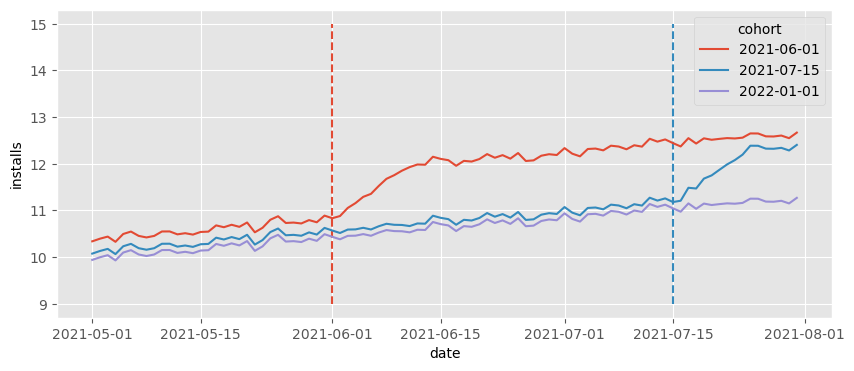

In [14]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_heter
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

설치 수는 여전히 이전과 동일한 수준에 도달하지만 설치까지 10일이라는 시간이 걸리는 것을 확인할 수 있습니다. 합리적으로 보이시나요? 우리가 실제로 보는 대부분의 데이터는 이와 같이 작동하며 효과가 성숙하는 데 시간이 걸립니다. 이제 이 데이터에 TWFE 모델을 실행하여 어떤 일이 발생하는지 확인해 보겠습니다.

In [15]:
formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_heter).fit()

print("Estimated Effect: ", twfe_model.params["treat"])
print("True Effect: ", df_heter.query("treat==1")["tau"].mean())

Estimated Effect:  0.7867708225724968
True Effect:  0.8544117647058823


먼저, 실제 ATT가 더 이상 1이 아니라는 점에 유의하세요. 처음 몇 기간 동안은 더 작아질 것이기 때문입니다. 둘째, 가장 중요한 것은 **TWFE의 추정 ATT가 더 이상 실제 ATT를 회복하지 못한다는 것입니다**. 간단히 말해서 TWFE는 편향되어 있습니다. 왜 그럴까요? 여기에는 평행 추세, 예상치 없음 및 기타 모든 엄격한 외생성 가정이 있습니다. 그렇다면 무슨 일이 일어나고 있는 걸까요?

무슨 일이 일어나고 있는지 이해하기 위한 첫 번째 단계는 TWFE가 실제로 여러 개의 2×2 Diff-in-Diff로 분해될 수 있다는 사실을 깨닫는 것입니다. 이 예에서는 초기 치료와 미치료, 후기 치료와 미치료, 초기 치료와 후기 치료(후기 치료가 대조군으로 사용됨), 후기 치료와 초기 치료(초기 치료가 대조군으로 사용됨)를 비교하는 방식이 될 수 있습니다:

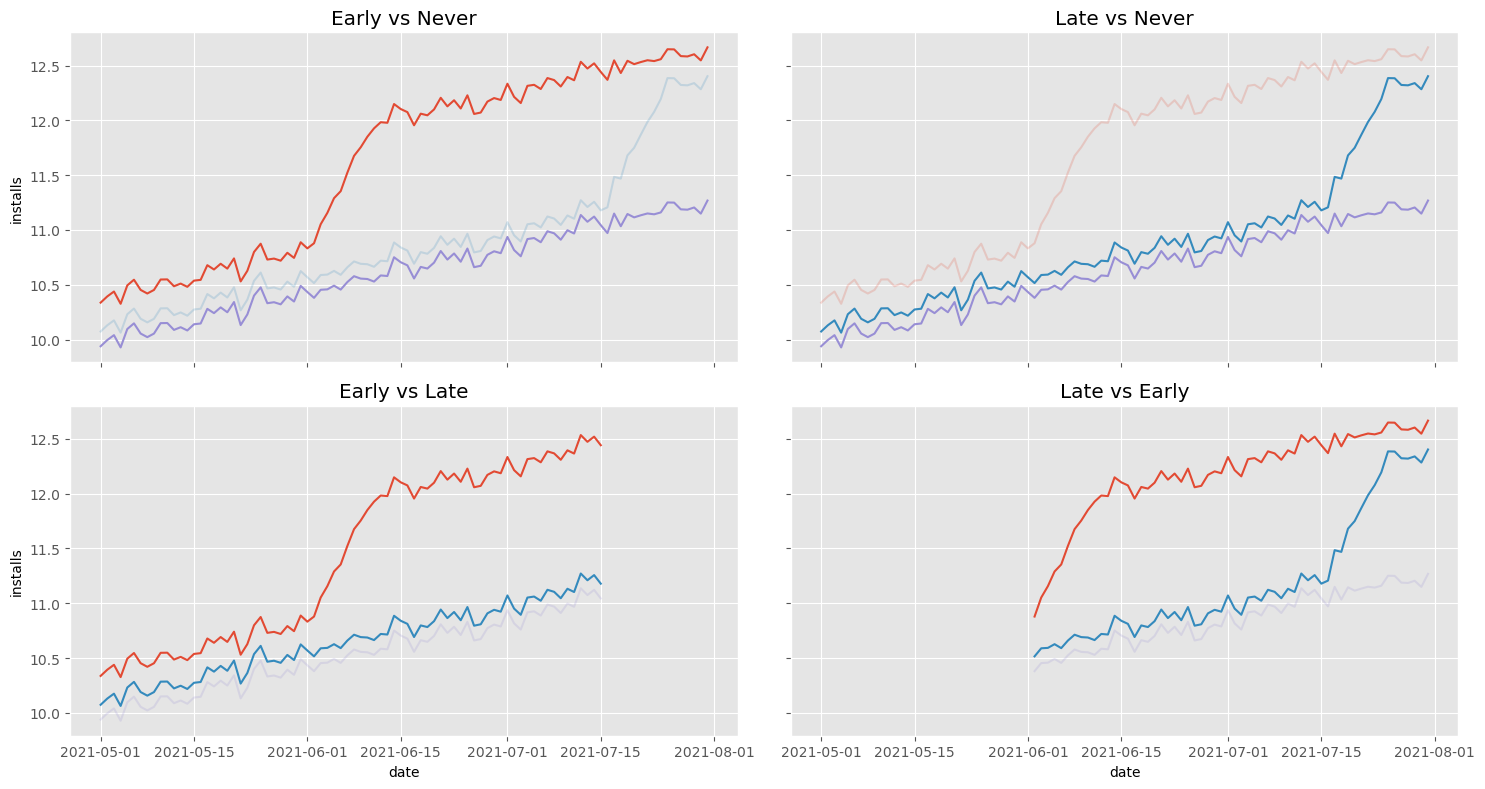

In [16]:
g_plot_data = (df_heter
               .groupby(["cohort", "date"])["installs"]
               .mean()
               .reset_index()
               .astype({"cohort":str}))


fig, axs = plt.subplots(2, 2, figsize=(15,8), sharex=True, sharey=True)

def plot_comp(df, ax, exclude_cohort, name):
    
    palette=dict(zip(map(str, cohorts), ["C0", "C1", "C2"]))
    
    sns.lineplot(
        data=df.query(f"cohort != '{exclude_cohort}'"),
        x="date",
        y="installs",
        hue="cohort",
        palette=palette,
        legend=None,
        ax=ax
    )

    sns.lineplot(
        data=df.query(f"cohort == '{exclude_cohort}'"),
        x="date",
        y = "installs",
        hue="cohort",
        palette=palette,
        alpha=0.2,
        legend=None,
        ax=ax
    )
    
    ax.set_title(name)

plot_comp(g_plot_data, axs[0,0], cohorts[1], "Early vs Never")
plot_comp(g_plot_data, axs[0,1], cohorts[0], "Late vs Never")

plot_comp(g_plot_data[g_plot_data["date"]<=cohorts[1]], axs[1,0], cohorts[-1], "Early vs Late")
plot_comp(g_plot_data[g_plot_data["date"]>cohorts[0]], axs[1,1], cohorts[-1], "Late vs Early")

plt.tight_layout();

처음 세 가지 비교는 대부분 제어로 사용하는 것이 매우 잘 작동하기 때문에 걱정할 이유가 없습니다. 그러나 네 번째 비교인 늦게 처리한 것과 일찍 처리한 것은 문제가 있습니다. 이 비교는 일찍 처리된 것을 대조군으로 사용합니다. 또한 이 초기 처리된 컨트롤의 행동이 이상하다는 것을 알 수 있습니다. 초반에 급격하게 상승합니다. 이는 ATT가 즉각적인 것이 아니라 성숙하는 데 10일이 걸린다는 것을 반영하는 것입니다. 직관적으로, 이렇게 하면 DiD의 역추세 추정이 엉망이 되어 실제보다 더 가파르게 된다는 것을 알 수 있습니다. 이를 시각화하기 위해 이 네 번째 그룹에서 늦게 치료한 경우의 추정된 역추세 $Y_0$를 플롯해 보겠습니다.

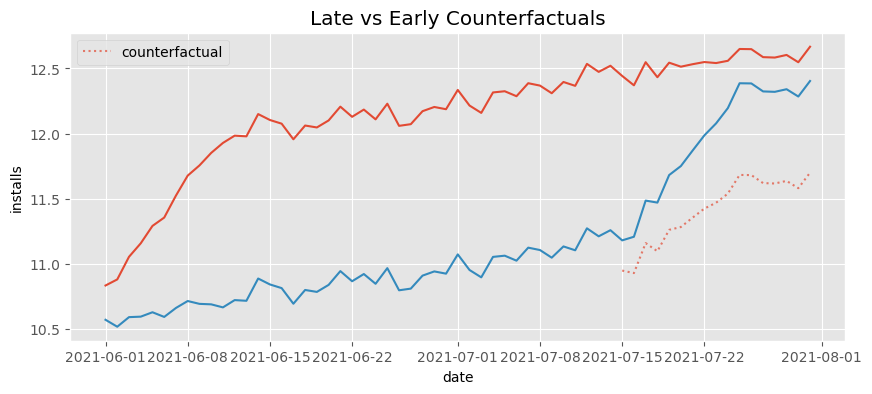

In [17]:
late_vs_early = (df_heter
                 [df_heter["date"].astype(str)>="2021-06-01"]
                 [lambda d: d["cohort"].astype(str)<="2021-08-01"])


formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=late_vs_early).fit()

late_vs_early_pred = (late_vs_early
                      .assign(**{"installs_hat_0": twfe_model.predict(late_vs_early.assign(**{"treat":0}))})
                      .groupby(["cohort", "date"])
                      [["installs", "installs_hat_0"]]
                      .mean()
                      .reset_index())


plt.figure(figsize=(10,4))
plt.title("Late vs Early Counterfactuals")
sns.lineplot(
    data=late_vs_early_pred,
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

sns.lineplot(
    data=(late_vs_early_pred
          [late_vs_early_pred["cohort"].astype(str) == "2021-07-15"]
          [lambda d: d["date"].astype(str) >= "2021-07-15"]
         ),
    x="date",
    y ="installs_hat_0",
    alpha=0.7,
    color="C0",
    ls="dotted",
    label="counterfactual"
);

앞서 말했듯이, 역추세는 예상보다 훨씬 가파른 추세를 보이고 있습니다. 이는 초기 치료 초기의 빠른 증가를 포착하고 이러한 추세를 후기 치료에 투영하는 것입니다.

좀 더 기술적으로, 엄격한 외생성(평행 추세, 예측 없음...) 하에서도 코호트의 크기가 동일한 경우 TWFE 추정기는 다음과 같이 수렴한다는 것을 보여줄 수 있습니다(Goodman-Bacon, 2019).

$$plim_{x\to \infty} \hat{\tau}^{TWFE} = VW\hspace{0.1mm}ATT - \Delta ATT$$

첫 번째 항은 앞서 살펴본 것과 같은 여러 DiD 비교의 분산 가중 ATT입니다. 이것이 우리가 원하는 것입니다. 그러나 추가 $\Delta ATT$ 항이 있습니다. 이는 시간이 지남에 따라 ATT가 얼마나 변화하는지를 나타내며, 추정치에 편향성을 부여합니다. 이 항을 보면, 위의 예에서처럼 시간이 지남에 따라 효과의 크기가 증가하면 하향 편향이, 시간이 지남에 따라 효과의 크기가 감소하면 상향 편향이 발생한다는 것을 알 수 있습니다.

위의 예에서는 TWFE의 효과가 실제 ATT보다 작다는 것을 확인했습니다. 그러나 상황은 훨씬 더 극단적일 수 있습니다. 마지막 예시를 통해 이러한 편향이 실제 ATT의 신호를 역전시킬 정도로 강할 수 있다는 것을 살펴볼 필요가 있습니다. 두 개의 코호트만 있는 매우 간단한 프로세스를 고려해 봅시다. 여기서 치료 효과는 음수이며 매일 0.1씩 감소합니다. 또한 시간 고정 효과와 추세를 모두 제거하여 실제로 무슨 일이 일어나고 있는지 확인할 수 있도록 했습니다.

In [18]:
date = pd.date_range("2021-05-15", "2021-07-01", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-06-15"])
units = range(1, 100+1)

np.random.seed(1)

df_min = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
)).assign(
    trend = 0,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 - d["trend"] + 0.1*d["unit_fe"]
).assign(
    y1 = lambda d: d["y0"] - 0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days))
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

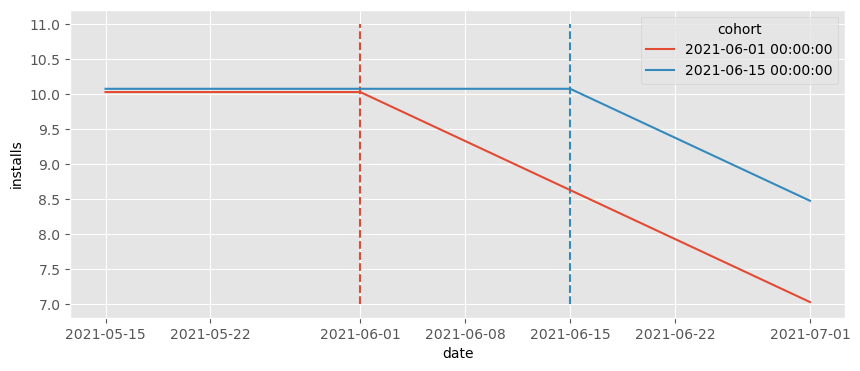

In [19]:
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_min
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

위의 플롯을 보면 ATT가 음수라는 것을 분명히 알 수 있습니다. 올바른 역설은 약 11의 직선이어야 합니다. 하지만 TWFE 추정기를 실행하면 긍정적인 효과를 얻을 수 있습니다!

In [21]:
formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_min).fit()

twfe_model.params["treat"]

0.049999999999961464

다시 한 번, 무슨 일이 일어나고 있는지 확인하려면 초기 치료를 받은 코호트가 후기 치료를 받은 코호트의 대조군 역할을 하는 비교에 주의를 집중하세요. DiD와 마찬가지로 TWFE는 대조군에서 치료군 수준으로 추세를 조정하므로, 대조군도 이를 반영해야 한다는 점을 기억하세요.

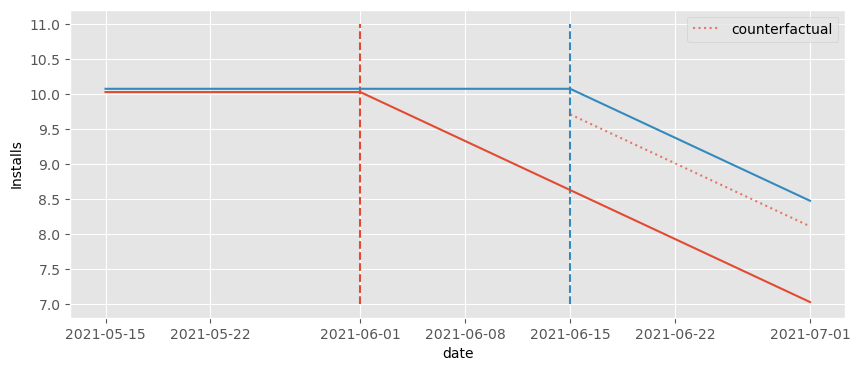

In [22]:
df_pred = df_min.assign(**{"installs_hat_0": twfe_model.predict(df_min.assign(**{"treat":0}))})
          
plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

역효과 레벨이 원래 위치에서 어떻게 밀려났는지 주목하세요. 초기 치료 그룹 효과가 감소하고 있다는 사실로 인해 이 수준이 10에서 약 9.5로 낮아졌습니다. 뿐만 아니라, 반대 사실도 존재하지 않아야 하는 하향 추세에 맞게 조정됩니다. 플롯을 보면 올바른 반실행은 10에서 직선이어야 하지만, 대조군으로 사용하는 초기 치료 그룹에서 보이는 것과 같은 하향 경사선이라는 것을 알 수 있습니다.

결과적으로 반대 사실인 $Y_0$이 실제로는 $Y_1$ 결과보다 낮아서 긍정적인 영향력 추정으로 이어집니다. 이것은 매우 어색합니다. 플롯만 보면 올바른 카운터팩추얼이 어디에 있어야 하는지(10의 직선)를 거의 알 수 있습니다. 하지만 TWFE는 단순히 초기 데이터를 사용하기 때문에 는 단순히 초기 처리된 데이터를 후기 처리된 데이터의 대조군으로 사용하기 때문입니다.

### Event Study Design

간단히 설명하자면, 치료 전후 각 기간에 더미를 하나씩 추가하는 이벤트 연구 설계를 통해 이 문제를 쉽게 해결할 수 있다고 생각하는 사람이 있을 수 있습니다. 이 경우 원래 TWFE 모델을 다음과 같이 대체합니다.

$$ Y_{i,t} = \tau^{-K}D_{i,t}^{<-K} + \sum_{k= -K}^{-2} \tau^{lead}D_{i,t}^k + \sum_{k= 0}^{L} \gamma^{lag}_k D_{i,t}^k + \gamma^{L+}_k D_{i,t}^{>L} + \gamma_i + e_{it}  $$ 
 
여기서 A는 이벤트 연구 더미로, 치료 후 `k` 기간이 지나면 1이 되고 그렇지 않으면 0이 됩니다. 지저분하고 복잡해 보이지만 몇 가지 코드를 통해 살펴보면 실제로는 매우 간단합니다. 치료가 시작되는 기간으로부터 단위가 얼마나 멀리 떨어져 있는지 측정하는 `relative_days` 열을 생성하기만 하면 됩니다.

In [23]:
df_min_rel = (df_min
              .assign(relative_days = (df_min["date"] - df_min["cohort"]).dt.days))

df_min_rel.head()

,date,unit,cohort,unit_fe,trend,day,treat,y0,y1,tau,installs,relative_days
0,2021-05-15,1,2021-06-15,-3.435864,0,0,0,9.656414,9.656414,0.0,9.656414,-31
1,2021-05-16,1,2021-06-15,-3.435864,0,1,0,9.656414,9.656414,0.0,9.656414,-30
2,2021-05-17,1,2021-06-15,-3.435864,0,2,0,9.656414,9.656414,0.0,9.656414,-29
3,2021-05-18,1,2021-06-15,-3.435864,0,3,0,9.656414,9.656414,0.0,9.656414,-28
4,2021-05-19,1,2021-06-15,-3.435864,0,4,0,9.656414,9.656414,0.0,9.656414,-27


그런 다음 해당 열을 카테고리로 전달하면 모델이 처리를 기준으로 각 기간의 예상 설치 수를 추정할 수 있습니다. 그런 다음 효과를 처리 전 마지막 날인 상대적 -1일과 비교한 추가 예상 설치 수로 정의할 수 있습니다.

이 공식이 ATT의 시간 이질성을 포착하고 모든 문제를 해결할 수 있을 것이라고 생각할 수 있습니다. 안타깝게도 그렇지 않습니다. 이 공식을 시도해보고 반대값을 그려보면 직관적으로 예상되는 위치(11번의 가로선)와는 거리가 멀다는 것을 알 수 있습니다.

In [24]:
# remove the intercept, otherwise effects will be relative to relative day -30
formula = f"installs ~ -1 + C(relative_days) + C(date) + C(unit)"

twfe_model = smf.ols(formula, data=df_min_rel).fit()

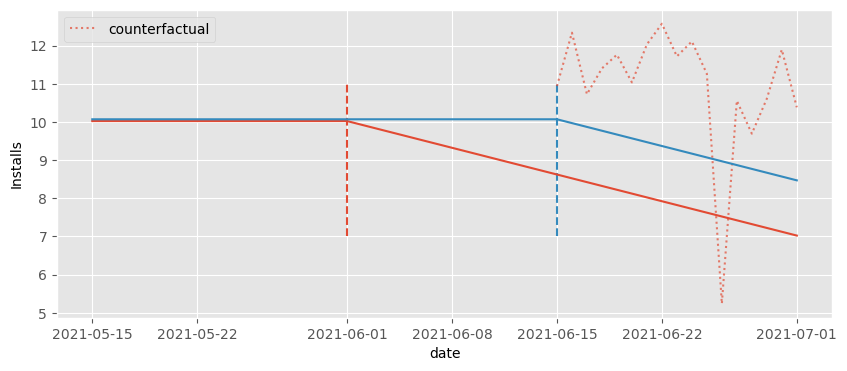

In [25]:
df_pred = df_min_rel.assign(
    installs_hat_0=twfe_model.predict(df_min_rel.assign(relative_days=-1))
) 

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

![img](./data/img/diff-in-diff-saga/awful.jpeg)

하지만 이러한 반증은 조금 더 낫습니다. 실현된 $Y_1$ 결과보다 높다는 것을 알 수 있습니다. 결과. 결과적으로, 우리는 최소한 부정적인 효과를 추정할 수 있습니다. 이를 확인하기 위해 먼저 각 더미와 관련된 매개 변수를 추출한 다음 상대적인 일 -1(기준선)과 관련된 매개 변수를 빼서 추정된 효과를 플로팅할 수 있습니다.

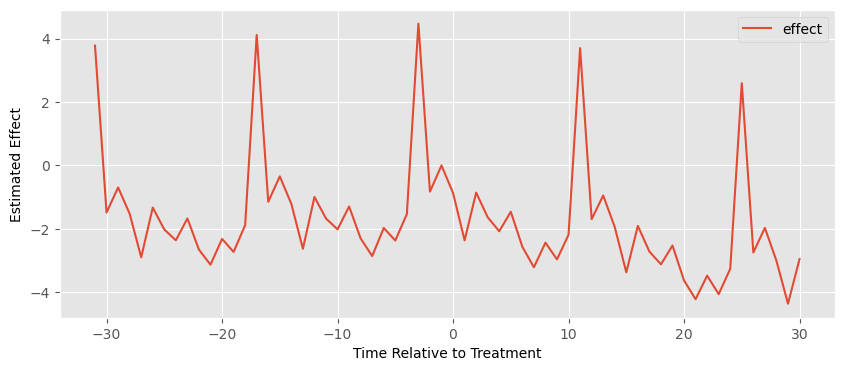

In [26]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("relative_days")]
           .reset_index()
           .rename(columns={0:"effect"})
           .assign(relative_day=lambda d: d["index"].str.extract(r'\[(.*)\]').astype(int))
           # set the baseline to period -1
           .assign(effect = lambda d: d["effect"] - d.query("relative_day==-1")["effect"].iloc[0]))

# effects
effects.plot(x="relative_day", y="effect", figsize=(10,4))
plt.ylabel("Estimated Effect")
plt.xlabel("Time Relative to Treatment");

적어도 치료 후 예상되는 효과는 1) 대부분 음수이고 2) 대부분 감소하기 때문에 조금 더 나은 것을 볼 수 있습니다. 그러나 이러한 이상한 스파이크와 긍정적인 치료 전 효과처럼 보이는 것이 있는데, 이는 분명히 말이 되지 않습니다.

여기서도 앞서 논의했던 것과 같은 문제가 있습니다. 치료 시기가 서로 다르기 때문에 일찍 치료한 유닛이 늦게 치료한 유닛의 대조군으로 사용되어 모델이 매우 이상한 역추세를 추정하게 됩니다. 결론은 치료 더미를 기준으로 시간을 추가한다고 해서 문제가 해결되지 않는다는 것인데, 정확히 무엇이 문제를 해결할 수 있을까요?

## 3) Enlightenment: A Flexible Functional Form

좋은 소식과 나쁜 소식이 있습니다. 먼저, 좋은 소식은 이 문제가 기능적 형태와 관련된 문제임을 확인했으므로 해당 형태를 수정하면 문제를 해결할 수 있다는 것입니다. 즉, 트위터에서는 TWFE의 이러한 특정 편향성이 시간 이질적 효과에서 비롯된다고 여러 번 언급했습니다. 이는 여러 가지 이유 중에서도 효과가 성숙하는 데 시간이 걸리기 때문에 발생할 수 있습니다(예: 마케팅 캠페인이 완전한 잠재력을 발휘하는 데 10일이 걸릴 수 있음). 즉, 기존 TWFE의 기능적 형태는 이러한 이질성을 포착할 수 있을 만큼 유연하지 않기 때문에 앞서 논의한 편향성을 초래할 수 있습니다. 대부분의 경우와 마찬가지로, 문제를 파악하는 것만으로도 해결책을 찾는 데는 이미 먼 길을 간 것입니다.

지난 섹션의 마지막 부분에서 단순히 치료와 관련하여 각 기간에 다른 효과를 허용하는 것(이벤트 연구 설계)만으로는 충분하지 않다는 것을 확인했습니다. 비록 효과가 없었지만 그 의도는 좋았습니다. 모델을 더 유연하게 만들긴 했지만 문제를 해결하는 방식은 아니었습니다. 이보다 더 유연하게 모델을 만들 수 있는 다른 방법을 생각해야 합니다.

이를 위해 새로운 기능(치료법)을 출시했을 때 증가하는 설치 수를 모델링하려고 했던 원래의 예로 돌아가 보겠습니다. 여기서는 단순한 TWFE 모델이 작동하지 않는다는 것을 알 수 있었습니다:

$$Installs_{it} = \tau D_{it} + \gamma_i + \theta_{t} + e_{it}$$

그 외에도 너무 제한적이기 때문에 작동하지 않는다는 것을 알고 있습니다. 이는 효과가 동일한 $\tau_{it}=\tau \ \forall i, t$, 즉 시간 동질성을 강제합니다. 이것이 문제라면 시간과 단위마다 다른 효과를 허용하는 것이 쉬운 해결책이 될 수 있습니다.

$$Installs_{it} = \sum_{i=0}^{N} \sum_{t=0}^T \tau D_{it} + \gamma_i + \theta_{t} + e_{it}$$

이는 아래 공식을 실행하는 것과 동일합니다:

>installs ~ treat:C(unit):C(date) + C(unit) + C(date)

안타깝게도 그렇게 할 수 없습니다. 데이터 포인트보다 더 많은 매개 변수가 필요하기 때문입니다. 날짜와 단위가 상호 작용하기 때문에 각 기간의 단위당 치료 효과 매개변수가 하나씩 $T*N$이 됩니다. 하지만 이것이 바로 우리가 가진 샘플 수입니다! 여기서 OLS는 실행되지도 않습니다.

이제 모델의 치료 효과 매개변수 수를 줄여야 합니다. 이를 위해 어떻게든 단위를 그룹화하는 방법을 생각해 볼 수 있습니다. 조금만 생각해보면, 코호트를 통해 단위를 그룹화하는 매우 자연스러운 방법을 알 수 있습니다! 우리는 전체 코호트의 효과가 시간이 지남에 따라 동일한 패턴을 따른다는 것을 알고 있습니다. 따라서 위의 비현실적인 모델을 자연스럽게 개선하는 방법은 단위가 아닌 코호트별로 효과를 변경할 수 있도록 하는 것입니다:

$$Installs_{it} = \sum_{g=0}^{G} \sum_{t=0}^T \tau_{gt} D_{it} + \gamma_i + \theta_{t} + e_{it}$$

여기서 `G`는 총 코호트 수이고 `g`는 각 개별 코호트를 표시합니다. 이 모델은 $G$가 일반적으로 $N$보다 훨씬 작기 때문에 훨씬 합리적인 수의 치료 효과 매개변수($T*G$)를 갖습니다. 이제 드디어 실행할 수 있습니다.


In [27]:
formula = f"""installs ~ treat:C(cohort):C(date) + C(unit) + C(date)"""

# for nicer plots latter on
df_heter_str = df_heter.astype({"cohort": str, "date":str})

twfe_model = smf.ols(formula, data=df_heter_str).fit()

이 모델이 작동하는지 확인하기 위해 모든 사람에게 `treat`가 0이 되도록 강제하여 $Y_0$에 대한 역 예측을 할 수 있습니다. 그런 다음 처치에 대해 관찰된 결과인 $Y_1$에서 $\hat{Y}_0$를 빼서 효과를 추정할 수 있습니다. 이것이 실제 ATT와 일치하는지 살펴봅시다.

In [28]:
df_pred = (df_heter_str
           .assign(**{"installs_hat_0": twfe_model.predict(df_heter_str.assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))

print("Number of param.:", len(twfe_model.params))
print("True Effect: ", df_pred.query("treat==1")["tau"].mean())
print("Pred. Effect: ", df_pred.query("treat==1")["effect_hat"].mean())

Number of param.: 467
True Effect:  0.8544117647058823
Pred. Effect:  0.8544117647058921


맞습니다! 마침내 시간 이질성을 포착할 수 있을 만큼 유연한 모델을 만들 수 있었고, 이를 통해 정확한 치료 효과를 추정할 수 있었습니다! 또 다른 멋진 방법은 시간 및 코호트별로 추정된 효과를 추출하여 플롯하는 것입니다. 이 경우 데이터가 어떻게 생성되었는지 알기 때문에 무엇을 기대할 수 있는지 알 수 있습니다. 즉, 각 코호트의 효과는 치료 전에는 0, 치료 10일 후에는 1, 그리고 치료와 치료 후 10일 사이의 기간에는 0에서 1로 올라가는 선이어야 합니다.

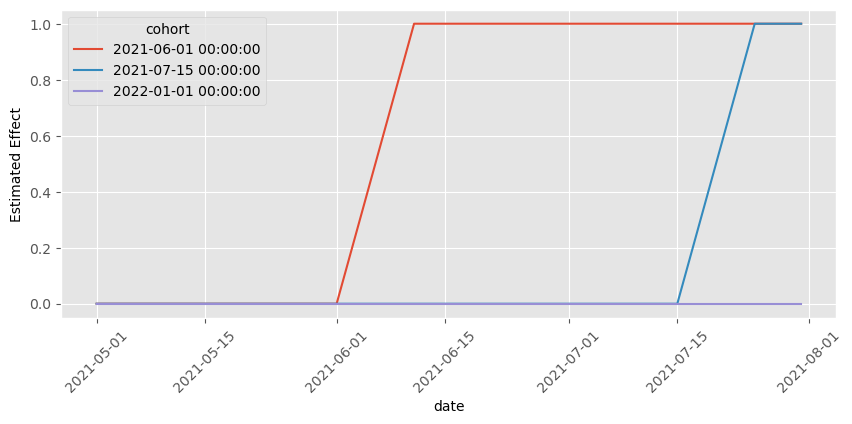

In [29]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r'C\(cohort\)\[(.*)\]:'))
           .assign(date=lambda d: d["index"].str.extract(r':C\(date\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date"]), cohort=lambda d: pd.to_datetime(d["cohort"])))

plt.figure(figsize=(10,4))
sns.lineplot(data=effects, x="date", y="param", hue="cohort")
plt.xticks(rotation=45)
plt.ylabel("Estimated Effect");

다시 한 번, 위의 플롯은 우리가 예상한 효과와 일치합니다. 위에서 설명한 정확한 패턴을 따르고 있습니다.

이것은 이미 매우 훌륭하지만 더 좋은 결과를 얻을 수 있습니다. 먼저, 이 모델에 엄청난 수의 매개변수가 있다는 점을 주목하세요. 데이터에 100개의 단위와 약 92일의 기간이 있으므로 이 중 192개의 매개 변수가 단위 및 시간 효과라는 것을 알 수 있습니다. 그래도 250개가 넘는 치료 효과 매개변수가 남습니다.

치료 전 효과가 0이라고 가정하면(기대 효과 없음), 상호작용 기간에서 치료 전 날짜를 삭제하여 매개변수의 수를 줄일 수 있습니다.

$$Installs_{it} = \sum_{g=0}^{G} \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_{t} + e_{it}$$
 
또한 치료 전 효과는 항상 0이므로 대조군 코호트를 상호작용에서 삭제할 수 있습니다.

$$Installs_{it} = \sum_{g=q}^{G} \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_{t} + e_{it}$$
 
여기서 $g<q$ 이전의 코호트를 대조 코호트로 정의합니다.

하지만 이는 수식으로 구현하기가 까다롭기 때문에 먼저 몇 가지 기능 엔지니어링을 수행해야 합니다. 즉, 코호트 더미를 수작업으로 생성하여 코호트가 2021-06-01이면 1, 그렇지 않으면 0이 되는 열을 만들고 코호트가 2021-07-15이면 1, 그렇지 않으면 0이 되는 열을 하나 더 만듭니다. 또한 2021-06-01 코호트에 대한 날짜 열을 만들어 해당 코호트 날짜 이전의 모든 날짜를 대조 카테고리로 축소합니다. 2021-07-15 코호트의 날짜에 대해서도 비슷한 작업을 수행할 수 있습니다. 다음은 코드의 모습입니다.

In [30]:
def feature_eng(df):
    return (
        df
        .assign(date_0601 = np.where(df["date"]>="2021-06-01", df["date"], "control"),
                date_0715 = np.where(df["date"]>="2021-07-15", df["date"], "control"),)
        .assign(cohort_0601 = (df["cohort"]=="2021-06-01").astype(float),
                cohort_0715 = (df["cohort"]=="2021-07-15").astype(float))
    )

formula = f"""installs ~ treat:cohort_0601:C(date_0601) 
                       + treat:cohort_0715:C(date_0715) 
                       + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df_heter_str.pipe(feature_eng)).fit()

이제 이전과 같이 사실과 반대되는 예측을 하면 추정 효과가 여전히 실제 효과와 완벽하게 일치하는 것을 볼 수 있습니다. 여기서 얻을 수 있는 이점은 치료 효과 매개변수가 약 80개에 불과한 훨씬 간단한 모델을 갖게 되었다는 것입니다(이 매개변수 중 192개는 시간 및 단위 고정 효과라는 점을 기억하세요).

In [31]:
df_pred = (df_heter
           .assign(**{"installs_hat_0": twfe_model.predict(df_heter_str
                                                           .pipe(feature_eng)
                                                           .assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))


print(len(twfe_model.params))
print("True Effect: ", df_pred.query("treat==1")["tau"].mean())
print("Pred Effect: ", df_pred.query("treat==1")["effect_hat"].mean())

271
True Effect:  0.8544117647058823
Pred Effect:  0.8544117647056794


치료 효과 매개변수를 플로팅하면 대조군 코호트에서 이러한 매개변수를 어떻게 제거했는지, 그리고 코호트를 치료하기 전 날짜에서 이러한 매개변수를 어떻게 제거했는지 확인할 수 있습니다.

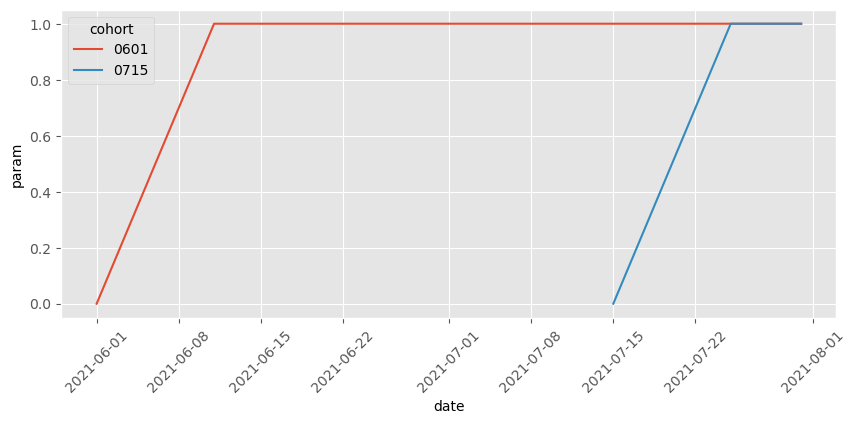

In [32]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r':cohort_(.*):'),
                   date_0601=lambda d: d["index"].str.extract(r':C\(date_0601\)\[(.*)\]'),
                   date_0715=lambda d: d["index"].str.extract(r':C\(date_0715\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date_0601"].combine_first(d["date_0715"]), errors="coerce")))

           
plt.figure(figsize=(10,4))
sns.lineplot(data=effects.dropna(subset=["date"]), x="date", y="param", hue="cohort")
plt.xticks(rotation=45);

두 집단에 대한 효과가 동일한 형태를 따르기 때문에 더 나아갈 수 있습니다. 즉, 두 집단 모두에 대해 동일한 효과를 가지며 시간이 지남에 따라만 변화하도록 모델을 제한할 수 있습니다. 이렇게 하려면 이벤트 연구 설계에서와 마찬가지로 치료 후 며칠을 나타내는 열을 만들어야 합니다. 다음과 같은 형식이 될 것입니다:

>days_after_treat=1(date>cohort)*(date - cohort)

그런 다음 치료 지표와 상호 작용합니다.

>installs ~ treat:C(days_after_treat) + C(unit) + C(date)

하지만 여기서 멈출 수 있다고 생각합니다. 치료 효과는 치료 후 시간뿐만 아니라 달력 시간에 따라 변하는 경향이 있기 때문에 코호트별 이질성을 허용하지 않는 것은 대개 나쁜 생각입니다. 예를 들어, 일정 시간이 지나면 경쟁업체가 해당 기능을 모방하여 더 이상 예전처럼 강력한 고객 유치 요소가 되지 않을 수 있습니다. 이 경우 새 기능이 설치에 미치는 영향은 시간이 지남에 따라 감소할 것입니다.

시간 경과에 따른 효과를 보여주는 것 외에 마지막으로 해야 할 일은 역효과가 적절한 위치에 있는지 확인하기 위해 플롯을 작성하는 것입니다. 이것이 우리 모델을 과학적으로 검증하는 것은 아니지만, 이 방법이 도움이 될 거라 믿습니다. 그래서 여기 있습니다.

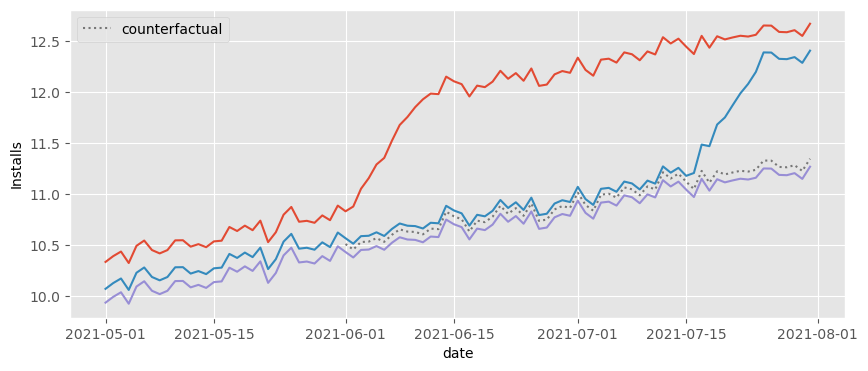

In [33]:
twfe_model_wrong = smf.ols("installs ~ treat + C(date) + C(unit)",
                           data=df_pred).fit()


df_pred = (df_pred
           .assign(**{"installs_hat_0_wrong": twfe_model_wrong.predict(df_pred.assign(**{"treat":0}))}))


plt.figure(figsize=(10,4))
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-01")]
          .groupby(["date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    ls="dotted",
    color="C3",
    label="counterfactual",
)

sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

plt.ylabel("Installs");

보시다시피, 사실과 반대되는 $Y_0$ 예측은 우리가 예상한 바로 그 지점, 즉 대조군 코호트에 매우 근접합니다. 이는 매우 위안이 됩니다. 우리는 TWFE 모델이 치료 효과를 $Y-\hat{Y}_0$으로 추정하고 있다는 것을 알고 있습니다. 즉, 치료받은 코호트의 결과를 반대 사실과 단순히 비교하는 것입니다. 반대 사실이 괜찮아 보이기 때문에 치료 효과도 괜찮을 것이라고 안심할 수 있습니다.

이것이 좋은 소식이지만, 제가 여러분께 약속한 나쁜 소식을 잊었다고 생각하지 마세요. TWFE로 기능적 형태 문제를 해결했지만, DiD와 TWFE에는 독립성 가정과 관련된 더 큰 문제가 여전히 존재한다는 것입니다.

우리는 종종 평행 추세 가정을 사용할 때, 그 가정이 정확히 무엇을 의미하는지 생각하지 않고 평행 추세 가정을 호출합니다. 안타깝게도 평행 추세 가정은 대부분의 사람들이 생각하는 것보다 훨씬 더 제한적이고 타당성이 떨어집니다. 하지만 이 장은 이미 너무 방대하기 때문에 여기서 끝내도 괜찮을 것 같고, 여기서 DiD의 작은 승리를 맛볼 수 있을 것 같습니다.

## Key Concept

드디어 TWFE의 기능적 형태 문제를 이해했을 뿐만 아니라 수정하는 데 성공했다고 말할 수 있을 것 같습니다. 우리는 문제의 뿌리(시간 이질성)까지 추적하여 더 많은 유연성을 허용함으로써 문제를 해결했습니다. 이제 TWFE가 다시 한 번 사용하기에 안전하다는 것을 알고 음료수를 마시며 휴식을 취할 수 있습니다. 그렇죠?

![img](./data/img/diff-in-diff-saga/twfeworking.png)

TWFE(그리고 더 일반적으로 DiD)는 **기능적 형태와 독립성 가정**이 모두 혼합되어 있다는 사실을 잊어서는 안 됩니다. 이 장에서는 기능적 형태 문제만 다루었지만, 평행 추세 가정이라는 큰 코끼리가 여전히 남아있습니다. 평행 추세는 독립성 가정입니다. 이것은 매우 잘 알려져 있습니다. 하지만 이 가정이 무엇을 의미하는지 잘 이해하지 못하는 것 같습니다. 우리는 이 가정을 마치 사실인 것처럼 아무렇게나 불러내곤 합니다. 안타깝게도 평행 추세 가정은 대부분의 사람들이 생각하는 것보다 훨씬 더 많은 것을 필요로 합니다. 다음 장에서는 그 이유와 이에 대해 우리가 무엇을 할 수 있는지, 또는 무엇을 할 수 있는지 살펴보겠습니다.

## Reference

이 장을 작성하는 데 (아주) 오랜 시간이 걸렸습니다. 최근 계량경제학 문헌에서는 DiD와 관련된 문제와 그 해결 방법에 대한 새로운 아이디어와 인사이트가 쏟아져 나오고 있습니다. 이러한 문제를 다양한 각도에서 바라볼 수 있으며, 이는 곧 문제를 해결하기 위해 활용할 수 있는 다양한 접근 방식으로 이어집니다. 참고 문헌 목록이 길어질 수 있으니 미리 양해해 주시기 바랍니다(아마 잘 정리되어 있지는 않을 것입니다).

먼저, 저는 Andrew Goodman-Bacon이 쓴 <치료 시기의 차이에 따른 차이의 차이>에서 많은 것을 배웠습니다. 문제에 대한 그의 진단은 매우 깔끔하고 직관적입니다. DiD에서 무슨 일이 일어나고 있는지 명확하게 이해할 수 있도록 도와주는 아주 멋진 그림이 함께 제공된 것은 말할 것도 없습니다. 이 장의 그림 중 일부는 굿맨-베이컨이 만든 그림을 거의 그대로 복사한 것입니다.

두 번째 주요 영감의 원천은 페드로 산탄나와 브런틀리 캘러웨이가 쓴 '여러 시간대의 차이'였습니다. 이 문제에 대한 캘러웨이와 산탄나의 해결책은 우리가 취한 방법과는 다른 길을 가고 있다는 점에 주목하세요. 그럼에도 불구하고 그들의 솔루션은 DiD 문제에 대해 많은 빛을 비춰주어 이해하기 쉽습니다. 논문은 차치하고서라도, 페드로는 TWFE의 문제점을 보여주는 아주 멋진 블로그 게시물을 가지고 있습니다. 그 블로그 포스트의 데이터 생성 프로세스는 제가 여기서 사용한 데이터 생성 프로세스에 많은 영감을 주었습니다. 저는 기본적으로 페드로의 코드를 R에서 Python으로 번역했습니다. 또한, 페드로는 DiD 가정에 대한 몇 가지 질문에 대해 매우 친절하게 도와주었습니다. 그는 DiD 모델에 공변량을 추가하는 문제를 다루는 또 다른 매우 흥미로운 논문을 가지고 있는데, 이 장이 너무 길어 여기서는 다루지 않았습니다. 논문 제목은 '이중 강건한 차이 내 차이 추정기'이며, 모델에 공변량을 추가할 계획이 있다면 꼭 읽어보시기를 강력히 추천합니다.

마지막으로, 여기서 사용한 함수형 수정은 이질적인 치료 효과가 있는 이벤트 연구에서 동적 치료 효과 추정(Estimating dynamic treatment effects in event studies with heterogeneous treatment effects)과 양방향 고정 효과, 양방향 문드락 회귀, 차이 내 추정기(Difference-in-Differences Estimators)에서 영감을 얻었습니다(Jeffrey Wooldridge의 저서). 저는 Callaway와 Sant'Anna의 논문이 마음에 들었지만, 그들의 솔루션은 구현하기가 조금 더 복잡합니다. 이와는 대조적으로 Sun, Abraham, Wooldridge의 솔루션은 TWFE 회귀 모델에서 상호작용을 교묘하게 다루기만 하면 되기 때문에 `statmodels`와 몇 가지 수식만 사용하여 매우 쉽게 구현할 수 있습니다.

위에서 언급한 논문 외에도 Taylor Wright가 유튜브에서 주최한 DiD 스터디 그룹에서 발표한 프레젠테이션도 참고했습니다. 위에 언급된 논문은 저자가 직접 설명하는 것을 먼저 보시면 훨씬 더 쉽게 이해할 수 있습니다. 또한, 이 모든 내용을 유튜브에서도 볼 수 있는 '패널 데이터를 사용한 인과적 추론' 강의 시리즈에서 정리해 주신 Yiqing Xu 교수님께도 감사의 말씀을 드립니다.

마지막으로, 저 역시 배우는 중이라는 점을 명심하시고, 터무니없는 부분이 있으면 문제를 제기해 주시면 최선을 다해 해결해 드리겠습니다.

## Contribute

Causal Inference for the Brave and True는 인과추론, 통계학에 대한 오픈소스 자료입니다. 이 자료는 금전적으로나 모든 분들이 쉽게 접근하실 수 있도록 하는 것이 목표입니다. 또한, 이 책은 Python 기반의 무료 소프트웨어만 사용해요.
여러분들께서 이 자료가 가치 있다고 생각하시고, 금전적으로 지원을 원하신다면 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)를 방문해주세요. 
만약 여러분이 금전적으로 기여하기가 쉽지 않으시다면, 오타 수정, 수정 제안, 이해하기 난해한 부분에 대한 피드백 제공 등을 통해 도움을 주실 수 있어요. 이 책의 Github 저장소 [이슈 페이지](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/issues)를 방문해주세요. 마지막으로 이 자료가 여러분의 마음에 드셨다면 도움이 될 수 있는 다른 사람들과 공유해주시고, [한국어 번역 자료](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/stargazers)와 [해당 번역본의 원서](https://github.com/matheusfacure/python-causality-handbook/stargazers)에 star 부탁드립니다!